In [118]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


In [119]:
# define constants and variables

# =============================constants=================

pi = np.pi

D = 2  # 浮标直径
r = 0.5 * D  # 浮标半径
v = 24 # ! 风速
H = 18 # ! 海平面高度

rho = 1025 # 海水密度
rho钢 = 7850 # 钢材密度
g = 9.81 # 重力加速度

m钢管 = 10 # 钢管的质量
m钢桶 = 100 # 钢桶的质量
m球  = 1200 # ! 求的质量
m浮标 = 1000 

L链 = 20.05 #! 锚链总长度
l = 105 * 10**(-3) #! 锚链单个链环的长度
delta = 7 # 锚链线密度
nMax = np.int64(  np.floor( L链 / l ) )# 锚链的数量

# 每个物体收到的浮力和重力
class mList : 
    """自定义列表类，并不存储数据，只通过getitem方法返回对应的值"""
    def __init__(self, getitem: callable):
        self.getitem = getitem
    
    def __getitem__(self, index):
        return self.getitem(index)
# 各部分的重力
def G_func(index):
    if 0 <= index < 4: # [0, 1, 2, 3] => 逻辑位序 [ 1, 2, 3, 4 ] 
        return m钢管 * g
    elif index ==  4: # * 4 => 钢桶
        return m钢桶 * g
    else: # * 锚链
        return delta * l * g

G = mList(G_func)

def F浮_func(index):
    if 0 <= index < 4: # 钢管 d=0.05m h=1m
        return (0.05 / 2)**2 * pi * 1 * rho * g
    elif index == 4: # 钢桶 d=0.3m h=1m
        return ( 0.3 / 2)**2 * pi * 1 * rho * g
    else: # 锚链 
        return l*delta / rho钢 * rho * g
    
F浮 = mList(F浮_func)

def L_func(index):
    if 0 <= index < 4: # 钢管
        return 1
    elif index == 4: # 钢桶
        return 1
    else: # 锚链
        return l

L = mList(L_func)

# =======================================

# 自定义 可调用对象类


class HObject:
    def __init__(self):

        self.dh = []
        self.Tcos = []
        self.Tsin = []
        # * 计算phi角度

    def clear(self):
        self.dh = []
        self.Tcos = []
        self.Tsin = []

    # @staticmethod
    def phi(self, index):
        ans = np.arctan( (2*self.Tsin[index] - (G[index] - F浮[index])) / (2*self.Tcos[index])  )
        if ans < 0:
            return 0
        else:
            return ans  



    def __call__(self, h):
        
        self.clear() # ! 清空数据
        # ? [0, 1, 2, 3] => 逻辑位序 [ 1, 2, 3, 4 ]  钢管
        # ? 4 => 5 桶
        # ? [5, ..., nMax+5-1] => 锚链

        # ? i = 0 => 第一段钢管
        self.Tcos.append( 0.625 * D * (2 - h) * v**2 )
        self.Tsin.append( rho * g * pi * r**2 * h - m浮标 * g)
        #? [1, 2, 3, 4] => 钢管和桶
        for i in range(1, 5): 
            # ! Tcos[i+1] = Tcos[i] 
            self.Tcos.append( self.Tcos[i-1] )
            # ! Tsin[i+1] = Tsin[i] - G[i] + F浮[i]
            self.Tsin.append( self.Tsin[i-1] - G[i] + F浮[i] )
        # ? 5 第一段锚链
        self.Tcos.append( self.Tcos[4] )
        self.Tsin.append( self.Tsin[4] - (m球*g - m球/rho钢*g*rho) - (G[4] - F浮[4]))


        # ! 钢管和桶 以及第一节锚链 [0, 1, 2, 3, 4, 5]
        for i in range(6):
            self.dh.append(L[i] * np.sin(self.phi(i)))
            # display(dh[i])


        # * 求解方程组: 逐节增加锚链 -> 求解h的值 -> 判断是否有解  -> 继续增加锚链

        for i in range(6, nMax+5):

            # ! 增加锚链
            self.Tcos.append( self.Tcos[i-1] )
            self.Tsin.append( self.Tsin[i-1] - G[i] + F浮[i] )

            # ! 计算phi角度
            phi_i = self.phi(i)

            # ! 计算各个物体的位移
            self.dh.append(L[i] * np.sin(phi_i))

        # ! 求和
        dh_sum = sum(self.dh)
        return dh_sum + h

# ! 实例化
H = HObject()


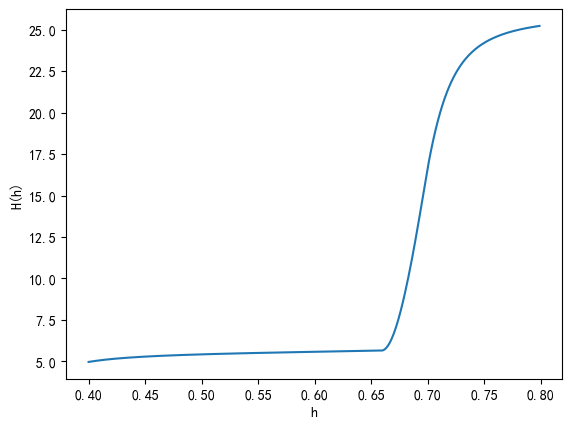

In [120]:
h = np.arange(0.4, 0.8, 0.001)

HArray = np.zeros(len(h))

for i in range(len(h)):
    HArray[i] = H(h[i])


plt.plot(h, HArray)
plt.xlabel('h')
plt.ylabel('H(h)')
plt.show()

In [121]:
# 保存数据为csv文件
import pandas as pd
import numpy as np

# 定义数据
data = {'h':h,'H':HArray}

# 转换为DataFrame
df = pd.DataFrame(data)

# 保存为csv文件
df.to_csv('../data/第一问数据.csv', index=False)

In [122]:
# 二分查找法求解问题一模型

import numpy as np
import pandas as pd

def binary_search(f:HObject, a, b,target, err=1e-6):
    assert a <= b
    mid = (a+b)/2
    fmid = f(mid)
    if abs(fmid-target) > err:
        if fmid > target:
            return binary_search(f, a, mid, target, err)
        else:
            return binary_search(f, mid, b, target, err)
    else:
        return [mid, fmid]

ans = binary_search(H, 0, 2, target=18)
# 保存结果
print(ans)
anscsv = pd.DataFrame({'h':[ans[0]], 'H':[ans[1]]})
anscsv.to_csv('../data/第一问结果.csv', index=False)

[0.70386952906847, 17.999999351576196]


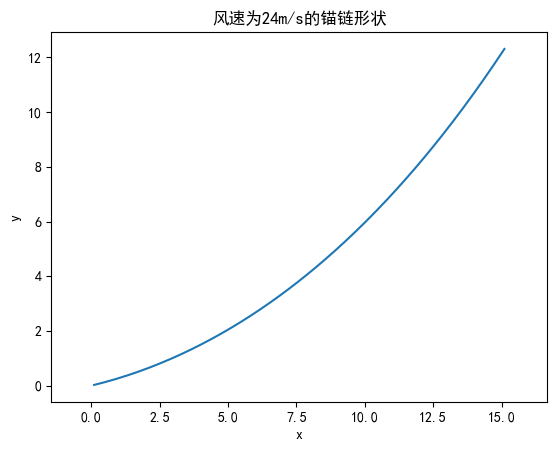

In [123]:

    
# * 实例化对象
obj = HObject()

# * 调用对象    
obj(ans[0])
dy = obj.dh[5:].copy()
dy = dy[::-1]
# dy = dy.map( lambda x: if x < 0: 0 else x )
# dy = [0 if x < 0 else x for x in dy]
y = np.cumsum(dy)

dx = [L[i] * np.cos(obj.phi(i)) for i in range(5,nMax+5)][::-1]
x = np.cumsum(dx)

plt.plot(x, y)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f"风速为{v}m/s的锚链形状")
plt.show()

In [124]:
for i in range(5):
    print(f"第{i+1}节钢管与竖直方向的夹角为{90 - obj.phi(i) * (180 / pi) :.4f}度")
print(f"浮标的游动区域半径为{np.sum([L[i] * np.cos(obj.phi(i)) for i in range(nMax+5)]):.4f}")

print(f"最后一节锚链与水平方向的夹角为{obj.phi(nMax+4) * (180 / pi) :.4f}度")

第1节钢管与竖直方向的夹角为4.3089度
第2节钢管与竖直方向的夹角为4.3362度
第3节钢管与竖直方向的夹角为4.3639度
第4节钢管与竖直方向的夹角为4.3919度
第5节钢管与竖直方向的夹角为4.5278度
浮标的游动区域半径为15.4865
最后一节锚链与水平方向的夹角为13.6425度
